# Regression with multiple variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib widget

So far, we've looked at cases where our dependent variable—the value we're trying to predict—depends on just one feature. For example, predicting `fixed acidity` from `density`. However, as mentioned previously, regression models can easily handle multiple features:

$$y = w_0 + w_1 \cdot \texttt{var}_1 + w_2 \cdot \texttt{var}_2 + \dots$$

All algorithms provided by scikit-learn naturally support this scenario. Let's now try predicting the wine's `fixed acidity` based on both `density` and `pH`. To do this, we need to adjust our `X` variable to include multiple features. We'll run the regression twice—once using a single feature, and once using two features—to compare the results clearly:


In [2]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [3]:
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
# The target (dependent) variable stays the same across both experiments
y = wine['fixed acidity']

# Experiment 1: Using only one feature
X_1 = wine[['density']]

# Experiment 2: Using two features
X_2 = wine[['density', 'pH']]
X_2.head()

,density,pH
0,0.9978,3.51
1,0.9968,3.20
2,0.9970,3.26
3,0.9980,3.16
4,0.9978,3.51


Now we can fit a model. We'll perform this twice: first using only the `density` feature, and then using both `density` and `pH`, so we can directly compare the results:

In [5]:
# Instantiate two different linear regression models
model_one = linear_model.LinearRegression()
model_two = linear_model.LinearRegression()

# Fit the models
res_one = model_one.fit(X=X_1, y=y)
res_two = model_two.fit(X=X_2, y=y)

In [6]:
# Coefficients learned by model one
res_one.coef_

array([616.28450984])

In [7]:
# Coefficients learned by model two
res_two.coef_

array([454.00256506,  -5.80584718])

In [8]:
# Intercept learned by model two
res_two.intercept_

np.float64(-424.9820945661193)

We see that the second model has two values in `coef_`, one for each feature (`density` and `pH`). Notice also that the coefficient $w_1$ for `density` has changed (454 compared to 662 previously). This difference is expected, since we're now optimizing the regression using two variables simultaneously.

Next, let's compare how this affects the overall error by calculating the sum of squared residuals:

In [9]:
# Generate predictions using model one and compute the mean squared error in one line
mse = mean_squared_error(res_one.predict(X_1), y)

# Print the mean squared error with three decimal places
print(f"Mean Squared Error for model one: {mse:.3f}")

Mean Squared Error for model one: 1.677


In [10]:
# Do the same for model two - we overwrite the variable mse since we don't need the old value anymore
mse = mean_squared_error(res_two.predict(X_2), y)

print(f"Mean Squared Error for model two: {mse:.3f}")

Mean Squared Error for model two: 0.968


Clearly, the fit using two variables captures more of the underlying information! Our model now represents a surface described by the function $z = f(x, y)$, where $z$ is the predicted `fixed acidity`, and the features $x$ and $y$ correspond to `density` and `pH`, respectively.

We can still visualize our model by creating two-dimensional plots for each feature separately. To do this, we simply ignore (or project out) one of the two features:

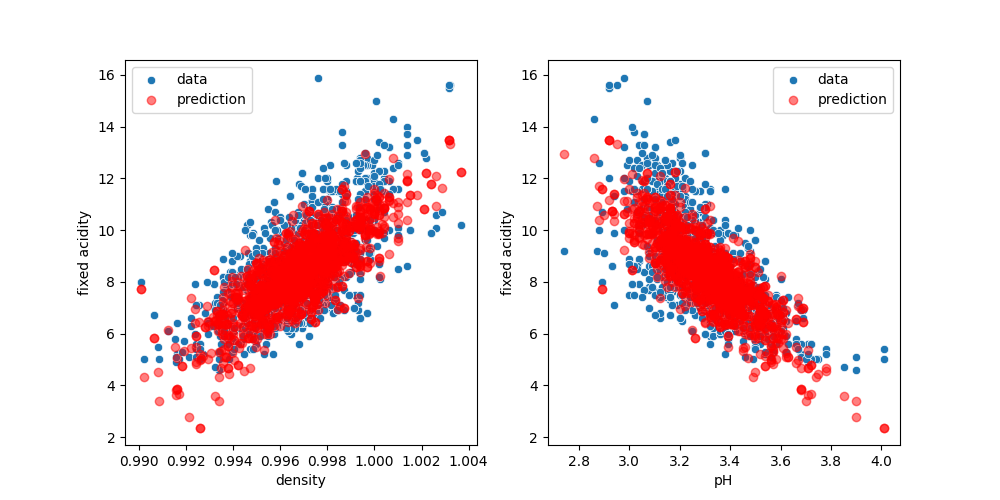

In [11]:
# Create a figure with two subplots (one row, two columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot showing the relationship between density and fixed acidity
sns.scatterplot(data=wine, x='density', y='fixed acidity', label='data', ax=ax[0])
ax[0].plot(X_2.density, res_two.predict(X_2), 'ro', alpha=0.5, label='prediction')

# Scatter plot showing the relationship between pH and fixed acidity
sns.scatterplot(data=wine, x='pH', y='fixed acidity', label='data', ax=ax[1])
ax[1].plot(X_2.pH, res_two.predict(X_2), 'ro', alpha=0.5, label='prediction')

ax[0].legend()
ax[1].legend();

We can also visualize our data and predictions together in a **3D scatter plot**, where the first two axes represent the features `density` and `pH`, and the third axis shows our target `fixed acidity`. Let's do this to see how the two-dimensional views we previously plotted can be represented in three dimensions.

We'll create a grid of combined `density` and `pH` values, predict the corresponding `fixed acidity` values, and plot these predictions. You'll notice that the predictions form a flat surface (plane) in 3D space:

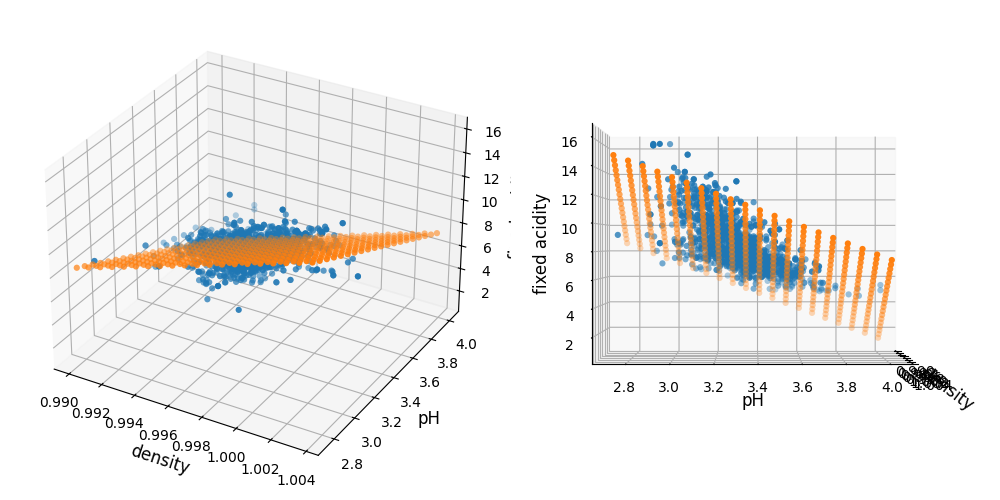

In [12]:
# Alternative way to create a figure, we will add two subplots to this figure later
fig = plt.figure(figsize=(10, 5))

X_1_grid, X_2_grid = np.meshgrid(
    # Here we use `np.linspace` instead of `np.arange`. In this case, the last argument is the number of points we want to generate and not the step size.
    np.linspace(wine.density.min(), wine.density.max(), 20),
    np.linspace(wine.pH.min(), wine.pH.max(), 20),
)

# The `ravel` operation transforms the 2D arrays into 1D arrays by concatenating all rows.
X_1_grid = X_1_grid.ravel()
X_2_grid = X_2_grid.ravel()

# Predict the values for the different combinations of density and pH
y_pred = res_two.predict(pd.DataFrame({'density': X_1_grid, 'pH': X_2_grid}))

# The actual values
x_1 = X_2.density.values
x_2 = X_2.pH.values
x_3 = y.values

# Create two subplots in the figure
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axes = [ax1, ax2]

for ax in axes:
    # Plot the surface of the actual values in the dataset
    surf = ax.scatter(x_1, x_2, x_3, linewidth=0)

    # Plot the surface of the predicted values across the grid
    surf = ax.scatter(X_1_grid, X_2_grid, y_pred, linewidth=0)

    ax.set_xlabel('density', fontdict={'fontsize': 12})
    ax.set_ylabel('pH', fontdict={'fontsize': 12})
    ax.set_zlabel('fixed acidity', fontdict={'fontsize': 12})

# Rotate the view
ax2.view_init(elev=0., azim=0)

fig.tight_layout()

## Features on Different Scales

When working with multiple features, a common issue is that they often have very different scales. In the `wine` dataset, for instance, there's roughly an order-of-magnitude difference between `fixed acidity` and `volatile acidity`. Since regression models typically minimize the overall distance between predicted and actual values across *all* features simultaneously, features with larger magnitudes can disproportionately affect the result.

For example, if we switch from `LinearRegressor` to a `Ridge` regressor without scaling our data first, the model fitting might fail or produce incorrect results:

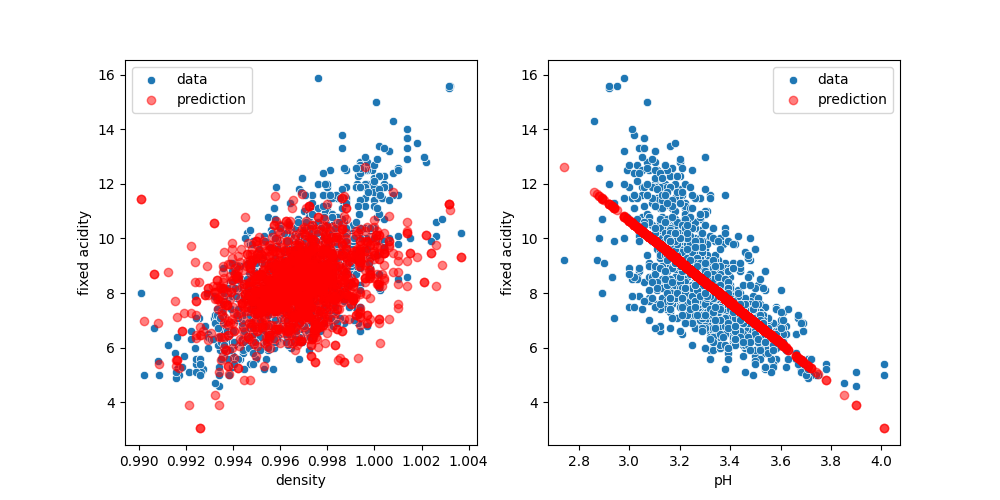

In [13]:
# Use a Ridge regression model instead of a linear regression model
model = linear_model.Ridge()
res_ridge = model.fit(X=X_2, y=y)

fig, ax = plt.subplots(1,2, figsize=(10,5))

# Scatter plot showing the relationship between density and fixed acidity
sns.scatterplot(data=wine, x='density', y='fixed acidity', label='data', ax=ax[0])

# Plot the predictions of the Ridge regression model against the density
ax[0].plot(X_2.density, res_ridge.predict(X_2), 'ro', alpha=0.5, label='prediction')

# Scatter plot showing the relationship between pH and fixed acidity
sns.scatterplot(data=wine, x='pH', y='fixed acidity', label='data', ax=ax[1])

# Plot the predictions of the Ridge regression model against the pH
ax[1].plot(X_2.pH, res_ridge.predict(X_2), 'ro', alpha=0.5, label='prediction')

ax[0].legend()
ax[1].legend();

Ridge regression helps prevent individual features from disproportionately influencing the model, which could lead to overfitting or misinterpretation. To ensure each feature contributes equally, we typically **normalize** them by adjusting their scales. Normalization sets each feature's mean to 0 and its standard deviation to 1.

In the example below, we have two variables: one centered around 4 with a spread (standard deviation) of 1, and another centered around 10 with a spread of 5.

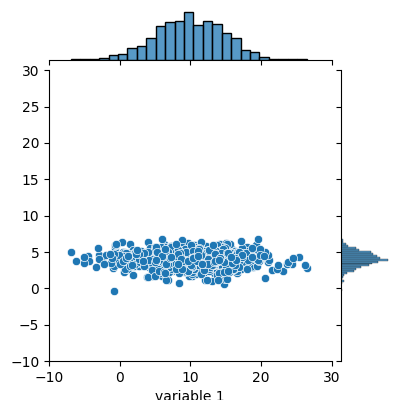

In [14]:
# We can create a new dataframe by specyfing the column names and values unside a dictionary
variables = pd.DataFrame(
    {
        'variable 1': np.random.normal(loc=10, scale=5, size=1000),
        'variable 2': np.random.normal(loc=4, scale=1, size=1000)
    }
)

# Jointplot is a figure-level function, it will automatically create a new figure for us
jpl = sns.jointplot(data=variables, x='variable 1', y='variable 2', xlim=(-10, 30), ylim=(-10, 30))

# Set the size of the figure
jpl.figure.set_size_inches(w=4, h=4)

The goal is to transform these points so that they have similar distributions. For that we have to shift them (subtraction) so that they are centered around 0 and divide them by a certain factor so that they have the same spread:

In [15]:
variables['variable 1'] = (variables['variable 1'] - np.mean(variables['variable 1'])) / np.std(variables['variable 1'])
variables['variable 2'] = (variables['variable 2'] - np.mean(variables['variable 2'])) / np.std(variables['variable 2'])

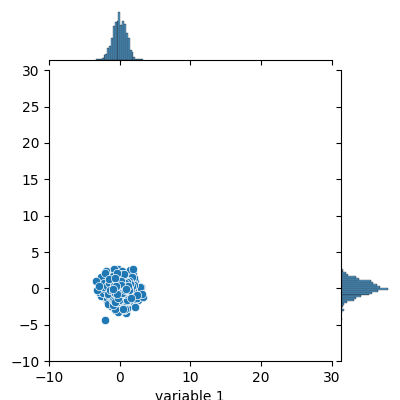

In [16]:
jpl = sns.jointplot(data=variables,
              x='variable 1', y='variable 2', xlim=(-10,30), ylim=(-10,30)
)
jpl.figure.set_size_inches(w=4, h=4)

We see that now the two variables have similar distributions centered around 0 and with a spead of 1. Instead of doing this operation manually we can use a ```preprocessing``` function from sklearn:

In [17]:
from sklearn import preprocessing

Here we use the `StandardScaler` to normalize our data. Just like our models, the scaler is used in two steps:

1. **Instantiate** the scaler.
2. **Fit and transform** the data. In this step, we calculate the mean and standard deviation and then normalize our data accordingly. Since we perform both operations, we use the `fit_transform` method instead of just `fit`.

We can apply `StandardScaler` directly to our entire DataFrame. Because it returns a NumPy array, we convert the result back into a DataFrame:

In [18]:
# Instantiate the StandardScaler
sc = preprocessing.StandardScaler()

# Fit the scaler to the wine dataset and transform it, then convert it back to a DataFrame
wine_scaled = pd.DataFrame(sc.fit_transform(wine), columns=wine.columns)

Let's make a histogram of before/after normalization of the ```pH```:

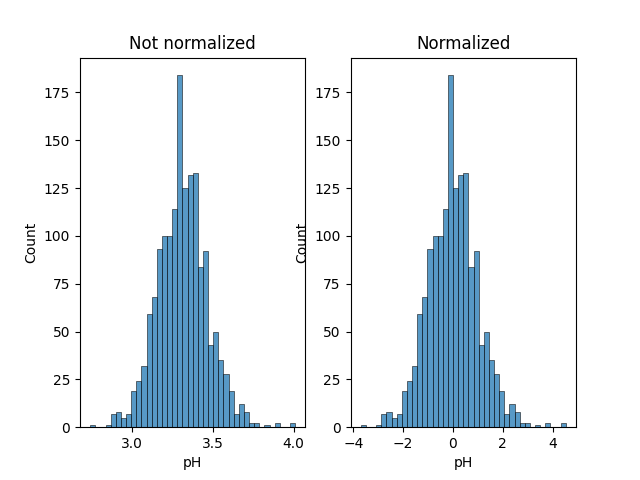

In [19]:
fig, ax = plt.subplots(1, 2)

# Before normalization
sns.histplot(wine.pH, ax=ax[0])
ax[0].set_title('Not normalized')

# After normalization
sns.histplot(wine_scaled.pH, ax=ax[1])
ax[1].set_title('Normalized');


We see that it doesn't affect the shape of the distribution, just its scale (see the `pH` values on the x-axis). Now we can try to fit a Ridge regression model again:

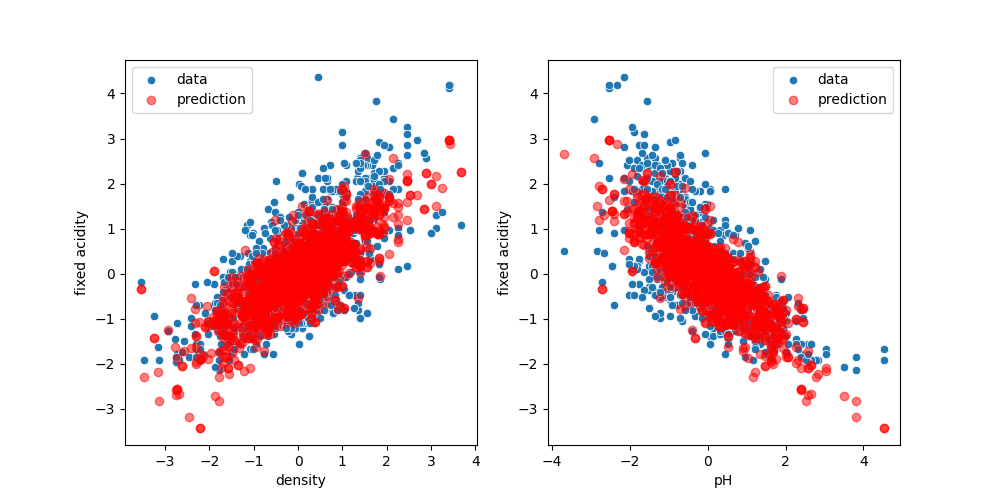

In [20]:
X_2_scaled = wine_scaled[['density', 'pH']]
y_scaled = wine_scaled['fixed acidity']

model = linear_model.Ridge()

res_ridge = model.fit(X=X_2_scaled, y=y_scaled)

fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=wine_scaled, x='density', y='fixed acidity', label='data', ax=ax[0])
ax[0].plot(X_2_scaled.density, res_ridge.predict(X_2_scaled), 'ro', alpha=0.5, label='prediction')

sns.scatterplot(data=wine_scaled, x='pH', y='fixed acidity', label='data', ax=ax[1])
ax[1].plot(X_2_scaled.pH, res_ridge.predict(X_2_scaled), 'ro', alpha=0.5, label='prediction')

ax[0].legend()
ax[1].legend();

We see that now the model was able to learn the relationship as with the linear regression before because we are not giving more weight to a particular feature anymore.

## Exercise

1. Import the `housing.csv` dataset from the datasets directory. This dataset contains information about houses sold in Kings County (California) such as price, surface etc. **Note** that this is not exactly the same dataset as `kc_house_data.csv`!

2. Predict the ```price``` using first only the ```grade``` and then the ```grade```, ```bedrooms``` and ```bathrooms``` columns

3. Compute the mean square error for both models. Which one is better and how big is the difference?

4. Make a pairplot with the ```bedrooms```, ```grade``` and ```price``` columns. Do you see anything special regarding the ```bedrooms``` data? If yes try to fix it and rerun the above analysis. What do you observe?